# Part 1: EDA

**1. Overview of dataset [15%]**
a. Summarize the background of the dataset.
b. State the size of the dataset.
c. For each variable, describe what it represents and its data type (numerical or categorical).

**2. Data pre-processing [35%]**
a. For each variable, determine the percentage of missing data. For any column with missing data, describe how you resolve the issue. Clearly state any assumption you made.
b. For each variable, identify outliers (if any) and describe how you resolve the issue. Clearly state any assumption you made.
c. For categorical variables, perform the necessary encoding.

**3. Exploratory analysis and visualization [50%]**
a. For each variable, provide relevant summary statistics.
b. For each variable, provide an appropriate visualisation depicting the distribution of its values, and summarize any key observation(s) you made.
c. Perform bi-variate analyses on the variables. You do not need to analyse every pair; only focus on the pairs you believe are worth investigating and explain your choices. For each pair, describe the relationship between the two variables. Use appropriate statistical methods and/or visualization.

If applicable, corresponding codes that are reproducible (i.e., they produce output consistent with your answers), and well documented (in the form of comments and markdown cells).

In [61]:
# Imported libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading of Dataset

In [4]:
df = pd.read_csv("employee.csv")
df

,Date,Emp_ID,Age,Gender,City,Education,Salary,Join_Date,Last_Work_Date,Join_Designation,Designation,Total_Sales_Acquired,Quarterly_Rating
0,1/3/2016,1,28,Male,C23,Master,57387,24/12/2015,11/3/2016,1.0,1,1715580,2
1,1/12/2017,2,31,Male,C7,Master,67016,6/11/2017,NaN,NaN,2,0,1
2,1/4/2017,4,43,Male,C13,Master,65603,7/12/2016,27/4/2017,2.0,2,350000,1
3,1/3/2016,5,29,Male,C9,College,46368,9/1/2016,7/3/2016,1.0,1,120360,1
4,1/12/2017,6,31,Female,C11,Bachelor,80874,31/7/2017,NaN,3.0,3,1265000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,1/12/2017,2784,34,Male,C24,College,82815,15/10/2012,NaN,2.0,3,21748820,4
2377,1/10/2017,2785,34,Female,C9,College,12105,28/8/2017,28/10/2017,1.0,1,0,1
2378,1/9/2016,2786,45,Male,C19,College,35370,31/7/2015,22/9/2016,2.0,2,2815090,1
2379,1/6/2016,2787,28,Female,C20,Master,69498,21/7/2015,20/6/2016,1.0,1,977830,1


## 1. Overview of dataset

### a. Summarize the background of the dataset.
The dataset contains HR data related to a sales team. Specifically the dataset captures employees’ information at the beginning of each month, including if the employee quit in that given month, total sales acquired so far in his/her career and his/her latest quarterly rating. The dataset contains 2381 rows and 13 columns.

| Column Name | Description | Type | Details |
| ----------- | ----------- | ---- | ------- |
| Date | Record capture date | Categorical | Date in format DD/MM/YYYY |
| Emp_ID | Employee ID | Categorical |
| Age | Age | Numerical |
| Gender | Gender | Categorical | "Male", "Female" |
| City | City where employee works | Categorical | "C1", "C2", ..., "C29" |
| Education | Highest education level of employee | Categorical | "College", "Bachelor", "Master" |
| Salary | Last drawn salary | Numerical |
| Join_Date | Date of joining the sales team | Categorical | Date in format DD/MM/YYYY |
| Last_Work_Date | Last working date with the sales team | Categorical | Date in format DD/MM/YYYY. If employee does not quit in the given month where record is captured, the field would be empty (NaN). |
| Join_Designation | Designation level when first joined | Categorical | 1, 2, 3, 4, 5. |
| Designation | Designation level at the time record is captured | Categorical | 1, 2, 3, 4, 5 |
| Total_Sales_Acquired | Total sales generated by employee since joining the team | Numerical |
| Quarterly_Rating | Latest quarterly performance rating | Categorical | 1, 2, 3, 4 |



In [7]:
# get rows and columns (size) of dataframe
n_rows, n_cols = df.shape

print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")

Number of rows: 2381
Number of columns: 13


In [9]:
# get datatype of attributes/features
df.dtypes

Date                     object
Emp_ID                    int64
Age                       int64
Gender                   object
City                     object
Education                object
Salary                    int64
Join_Date                object
Last_Work_Date           object
Join_Designation        float64
Designation               int64
Total_Sales_Acquired      int64
Quarterly_Rating          int64
dtype: object

In [11]:
# analysing unique values of specific columns
genders = df["Gender"].unique()
cities = df["City"].unique()
education_levels = df["Education"].unique()
join_designation_levels = df["Join_Designation"].unique()
designation_levels = df["Designation"].unique()
quarterly_ratings = df["Quarterly_Rating"].unique()

print(f"Possible values of 'Gender' attribute: {genders}")
print(f"Possible values of 'City' attribute: {cities}")
print(f"Possible values of 'Education' attribute: {education_levels}")
print(f"Possible values of 'Join_Designation' attribute: {join_designation_levels}")
print(f"Possible values of 'Designation' attribute: {designation_levels}")
print(f"Possible values of 'Quarterly_Rating' attribute: {quarterly_ratings}")

Possible values of 'Gender' attribute: ['Male' 'Female']
Possible values of 'City' attribute: ['C23' 'C7' 'C13' 'C9' 'C11' 'C2' 'C19' 'C26' 'C20' 'C17' 'C29' 'C10'
 'C24' 'C14' 'C6' 'C28' 'C5' 'C18' 'C27' 'C15' 'C8' 'C25' 'C21' 'C1' 'C4'
 'C3' 'C16' 'C22' 'C12']
Possible values of 'Education' attribute: ['Master' 'College' 'Bachelor']
Possible values of 'Join_Designation' attribute: [ 1. nan  2.  3.  4.  5.]
Possible values of 'Designation' attribute: [1 2 3 4 5]
Possible values of 'Quarterly_Rating' attribute: [2 1 4 3]


## 2. Data pre-processing

In [13]:
# number of available data
df.count()

Date                    2381
Emp_ID                  2381
Age                     2381
Gender                  2381
City                    2381
Education               2381
Salary                  2381
Join_Date               2263
Last_Work_Date          1616
Join_Designation        2276
Designation             2381
Total_Sales_Acquired    2381
Quarterly_Rating        2381
dtype: int64

In [15]:
# percentage of data missing per attribute
print("Percentage of data missing")

col = df.columns
i = 0
missing_data_col = []

for valid_data in df.count():
    print(col[i], end=" = ")
    per_missing = (1 - (valid_data/n_rows))*100
    print(f"{per_missing : .2f}%")

    if per_missing > 0:
        missing_data_col.append(col[i])
        
    i += 1
print()

# print all column names of columns with missing data
print("Columns with missing data: " + str(missing_data_col))

Percentage of data missing
Date =  0.00%
Emp_ID =  0.00%
Age =  0.00%
Gender =  0.00%
City =  0.00%
Education =  0.00%
Salary =  0.00%
Join_Date =  4.96%
Last_Work_Date =  32.13%
Join_Designation =  4.41%
Designation =  0.00%
Total_Sales_Acquired =  0.00%
Quarterly_Rating =  0.00%

Columns with missing data: ['Join_Date', 'Last_Work_Date', 'Join_Designation']


### Missing Data
| Column Name | Percentage Missing | Resolution Technique | Assumptions |
| ----------- | ------------------ | -------------------- | ----------- |
| Last_Work_Date | 32.13% | Impute NaN values as the date in the "Date" attribute and Impute a new attribute "Current_Staff" with those that have NaN values initialised as "Yes" and those that have Last_Work_Date as "No". | Fields with NaN values suggest that the staff is still with the company. |
| Join_Date | 4.96% | Impute NaN values as the average tenure of their salary group from their Last_Work_Date | There is a correlation between salary and the tenure length of a worker in the company. |
| Join_Designation | 4.41% | Impute the NaN values as 1. | All workers begin at the lowest Designation level when they joined the company. |

In [20]:
# Resolving Last_Work_Date
print(f"Last_Work_Date has been resolved: {df["Last_Work_Date"].count() == n_rows}")
df["Current_Staff"] = "No"
df.loc[df["Last_Work_Date"].isna(), "Current_Staff"] = "Yes"
df.loc[df["Last_Work_Date"].isna(), "Last_Work_Date"] = df["Date"]
print(f"Last_Work_Date has been resolved: {df["Last_Work_Date"].count() == n_rows}")

Last_Work_Date has been resolved: True
Last_Work_Date has been resolved: True


In [21]:
import pandas as pd
from datetime import datetime

# Convert date columns to datetime
df['Join_Date'] = pd.to_datetime(df['Join_Date'], format='%d/%m/%Y', errors='coerce')
df['Last_Work_Date'] = pd.to_datetime(df['Last_Work_Date'], format='%d/%m/%Y', errors='coerce')

# Filter employees with missing Join_Date
missing_join_df = df[df['Join_Date'].isna()]

# Filter employees with both Join_Date and Last_Work_Date
valid_join_df = df[df['Join_Date'].notna() & df['Last_Work_Date'].notna()]

# Calculate tenure in days for employees with valid join and last work dates
valid_join_df['Tenure'] = (valid_join_df['Last_Work_Date'] - valid_join_df['Join_Date']).dt.days

# Group by salary ranges (e.g., every 10,000)
valid_join_df['Salary_Range'] = pd.cut(valid_join_df['Salary'], bins=range(0, 150000, 10000))

# Calculate average tenure for each salary range
avg_tenure_by_salary = valid_join_df.groupby('Salary_Range')['Tenure'].mean()

# Function to estimate join date based on salary range
def estimate_join_date(row):
    salary_range = pd.cut([row['Salary']], bins=range(0, 150000, 10000))[0]
    if salary_range in avg_tenure_by_salary:
        avg_tenure = avg_tenure_by_salary[salary_range]
        if pd.notna(row['Last_Work_Date']):
            estimated_join_date = row['Last_Work_Date'] - pd.Timedelta(days=avg_tenure)
            return estimated_join_date
    return row['Last_Work_Date'] - pd.DateOffset(years=1)

# Update the original dataframe with estimated join dates
df.loc[missing_join_df.index, 'Join_Date'] = missing_join_df['Join_Date']

salary_group = df.groupby('Salary')

# Apply the estimation function
df['Join_Date'] = df.apply(lambda row: estimate_join_date(row), axis=1)

# Convert the estimated join date back to the original format
df['Join_Date'] = df['Join_Date'].dt.strftime('%d/%m/%Y')

# Print the updated DataFrame
print(df[['Emp_ID', 'Salary', 'Join_Date', 'Join_Date']])
# print(df['Join_Date'].count() / df['Emp_ID'].count() * 100)

/var/folders/9v/8w_t6l7d55d_9w7p9q_thgz00000gp/T/ipykernel_22397/3974724315.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_tenure_by_salary = valid_join_df.groupby('Salary_Range')['Tenure'].mean()


      Emp_ID  Salary   Join_Date   Join_Date
0          1   57387  17/02/2015  17/02/2015
1          2   67016  04/03/2016  04/03/2016
2          4   65603  17/06/2016  17/06/2016
3          5   46368  05/06/2015  05/06/2015
4          6   80874  20/12/2015  20/12/2015
...      ...     ...         ...         ...
2376    2784   82815  20/12/2015  20/12/2015
2377    2785   12105  01/04/2017  01/04/2017
2378    2786   35370  22/12/2015  22/12/2015
2379    2787   69498  11/08/2015  11/08/2015
2380    2788   70254  27/10/2015  27/10/2015

[2381 rows x 4 columns]


In [107]:
# Resolving Join_Designation
print(f"Join_Designation has been resolved: {df["Join_Designation"].count() == n_rows}")
df["Join_Designation"] = df["Join_Designation"].replace(np.nan, 1)

print(f"Join_Designation has been resolved: {df["Join_Designation"].count() == n_rows}")

Join_Designation has been resolved: True
Join_Designation has been resolved: True


In [26]:
# check if all NaN values have been handled

df.count()

Date                    2381
Emp_ID                  2381
Age                     2381
Gender                  2381
City                    2381
Education               2381
Salary                  2381
Join_Date               2381
Last_Work_Date          2381
Join_Designation        2381
Designation             2381
Total_Sales_Acquired    2381
Quarterly_Rating        2381
Current_Staff           2381
dtype: int64

## 3. EDA and Visualisation

1. Univariate
- histogram for Total_Sales_Acquired
- donut chart for designation level distribution
- pie chart for Quarterly_Rating distribution
- histogram for salary distribution
- histogram for age distribution
- pie chart for Gender distribution
- pie chart for Education level distribution


3. Bivariate
- grouped boxplot for Salary against Education level
- grouped boxplot for Salary against designation
- grouped boxplot for Salary against Gender
- grouped boxplot for Total_Sales_Acquired and Gender
- scatter plot for Salary against Age
- scatter plot for Total_Sales_Acquired against Age
- scatter plot for Total_Sales_Acquired against Salary


### Histogram of Total Acquired Sales

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


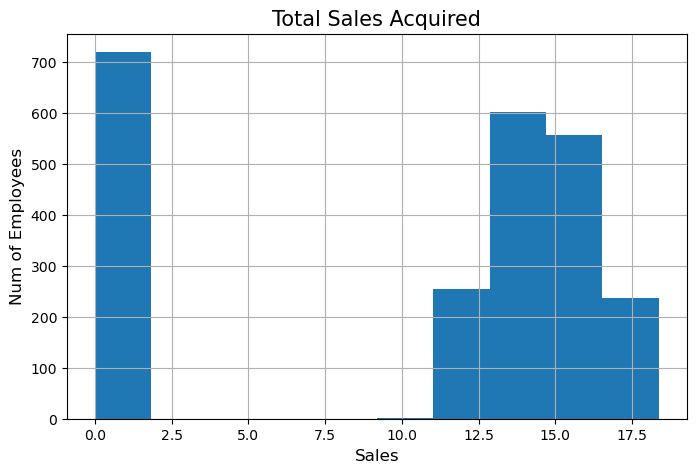

In [57]:
plt.figure(figsize=(8,5))
plt.title("Total Sales Acquired", fontsize=15)
plt.xlabel("Sales", fontsize=12)
plt.ylabel("Num of Employees", fontsize=12)
log_TotalSales = np.log1p(df.Total_Sales_Acquired)
log_TotalSales.hist(bins=10)  
plt.show()

In [56]:
# mean
print("Mean total sales acquired: " + str(df["Total_Sales_Acquired"].mean()))

# standard deviation
print("s.d. total sales acquired: " + str(df["Total_Sales_Acquired"].std()))

Mean total sales acquired: 4586172.487610248
s.d. total sales acquired: 9125766.81014095


### Total_Sales_Acquired
With a large standard deviation, it goes to show that the spread of the Total_Sales_Acquired across all employees in the company is rather large. The histogram plot also suggests that employees either produce very little to no sales or a lot of sales. Perhaps this suggests that the company has a significant proportion of employees that are not involved in sales. For more meaningful analysis, it could perhaps be more useful to categorise the type of employees.

### Doughnut Chart showing the Percentage of Workers in Each Designation Level

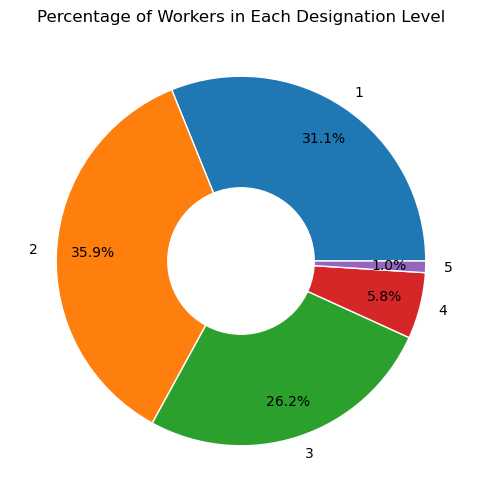

In [70]:
plt.figure(figsize=(6, 6))
plt.pie(df["Designation"].value_counts().sort_index(), labels=df["Designation"].unique(), autopct='%1.1f%%', wedgeprops={'edgecolor': 'white'}, pctdistance=.8)

# Create a circle at the center to make it a doughnut
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
plt.gca().add_artist(centre_circle)

# Title & Show Plot
plt.title("Percentage of Workers in Each Designation Level")
plt.show()

### Designation
It suggests that the Designation level 5 could correspond to the Directors of the company and with each Designation level in descending order suggesting a more junior level staff of the company. This is representative of a typical corporate organisational structure.

### Pie Chart showing the Percentage of Workers with Each Quarterly Rating

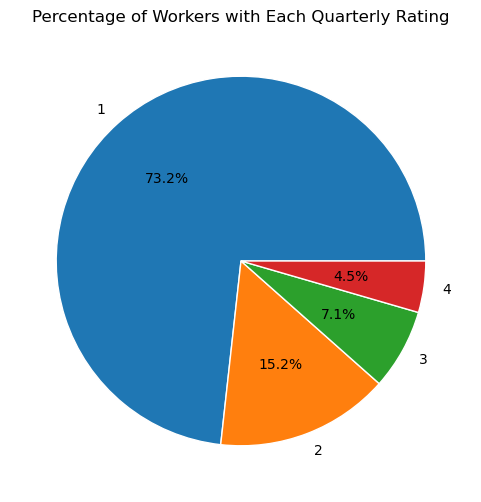

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(df["Quarterly_Rating"].value_counts().sort_index(), labels=sorted(df["Quarterly_Rating"].unique()), autopct='%1.1f%%', wedgeprops={'edgecolor': 'white'}, pctdistance=.6)

# Title & Show Plot
plt.title("Percentage of Workers with Each Quarterly Rating")
plt.show()

### Quarterly_Rating
The pie chart shows a breakdown of the proportion of employees in for each Quarterly_Rating band. Intuitively, this suggests that band 4 which makes up the smallest proportion of employees at 4.5% are the top performers for the quarter. A vast majority of employees are awarded band 1 at 73.2% of the all employees in the company.

### Histogram of the Salary of Employees

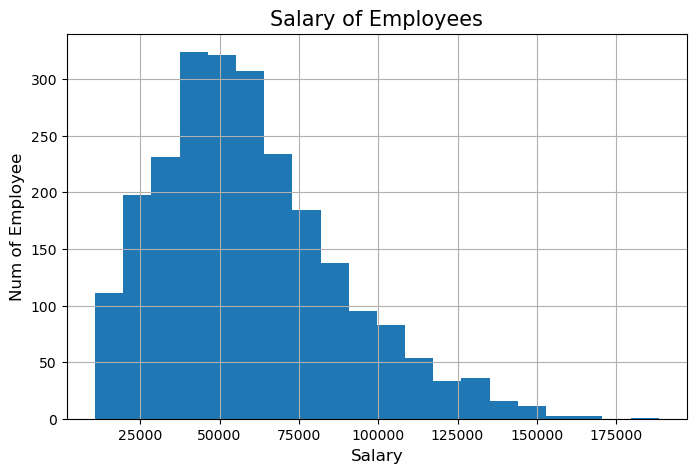

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Salary of Employees", fontsize=15)
plt.xlabel("Salary", fontsize=12)
plt.ylabel("Num of Employee", fontsize=12)
# log_Age = np.log1p(df.Age)
df["Salary"].hist(bins=20)  
plt.show()

In [62]:
print("Mean employee salary: " + str(df['Salary'].mean()))

print("s.d. employee salary: " + str(df['Salary'].std()))

Mean employee salary: 59336.12683746325
s.d. employee salary: 28377.306108529432


### Salary
The mean salary of employees in the company is $59336.13. Based on the histogram, the distributions of salary of employees seem to follow a normal distribution.

### Histogram of the Age of Employees

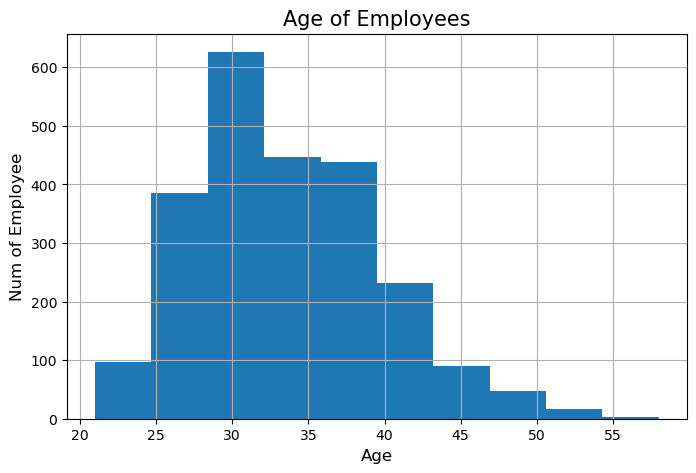

In [68]:
# Histogram for Age
plt.figure(figsize=(8,5))
plt.title("Age of Employees", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Num of Employee", fontsize=12)
# log_Age = np.log1p(df.Age)
df["Age"].hist(bins=10)  
plt.show()

In [65]:
print("Mean employee salary: " + str(df['Age'].mean()))

print("s.d. employee salary: " + str(df['Age'].std()))

Mean employee salary: 33.66316673666527
s.d. employee salary: 5.9833754182849646


### Age
Based on the histogram, it seems to imply that majority of the employees in the company are around 30 years of age. The mean age is 33.7 which suggests that the distribution of the age of employees tend more towards larger than 30 years of age than it does to less than 30 years of age.

### Gender

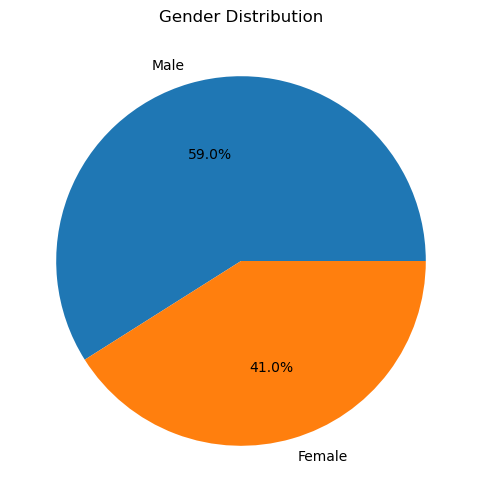

In [ ]:
x = df['Gender'].value_counts()
y = x.index
plt.figure(figsize=(6, 6)) #size
plt.pie(x, labels=y, autopct='%1.1f%%') #string format
plt.title("Gender Distribution")
plt.show()

### Education

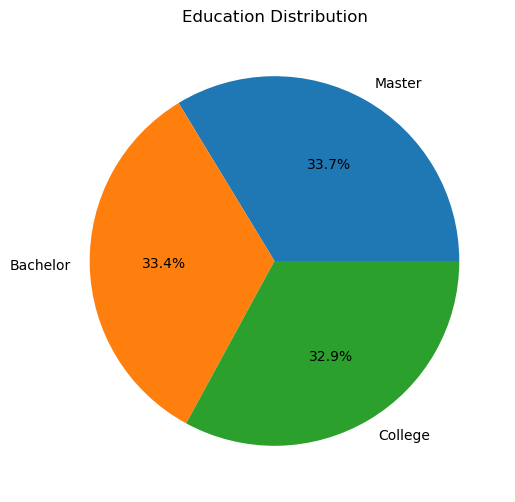

In [109]:
x1 = df['Education'].value_counts()
y1 = x1.index
plt.figure(figsize=(6, 6)) #size
plt.pie(x1, labels=y1, autopct='%1.1f%%') #string format
plt.title("Education Distribution")
plt.show()


### City Distribution

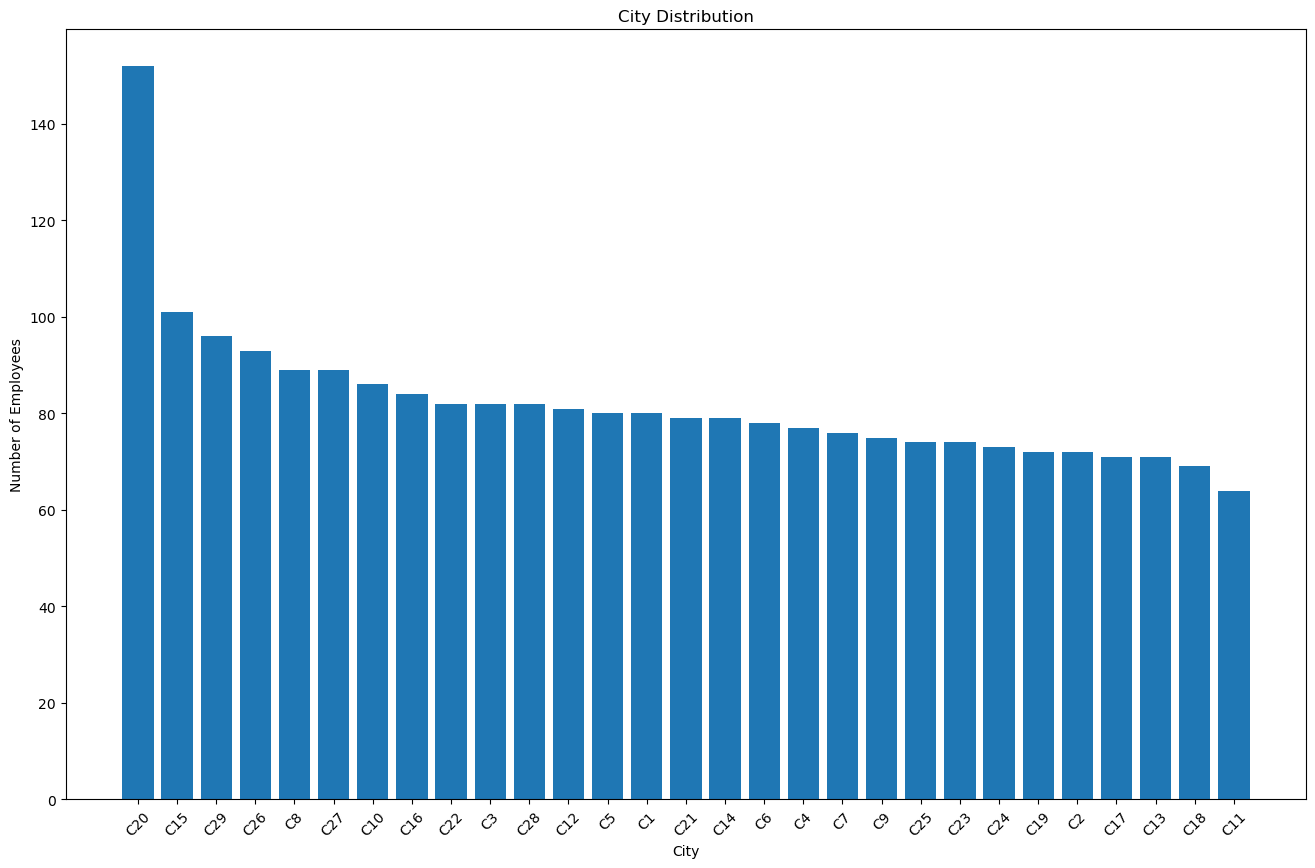

In [47]:
city_counts = df['City'].value_counts()

plt.figure(figsize=(16, 10))
plt.bar(city_counts.index, city_counts.values)

plt.title("City Distribution")
plt.xlabel("City")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45) 

plt.show()


## BiVariate

### Boxplot for Education and Salary
With reference to the boxplot, it shows that the average salary between the various education level do not vary by a significant amount.

However, it can be seen that with a higher level of education, there is a strong correlation to greater salary as seen by a larger number of outliers receiving a higher salary for those employees that has a Master degree

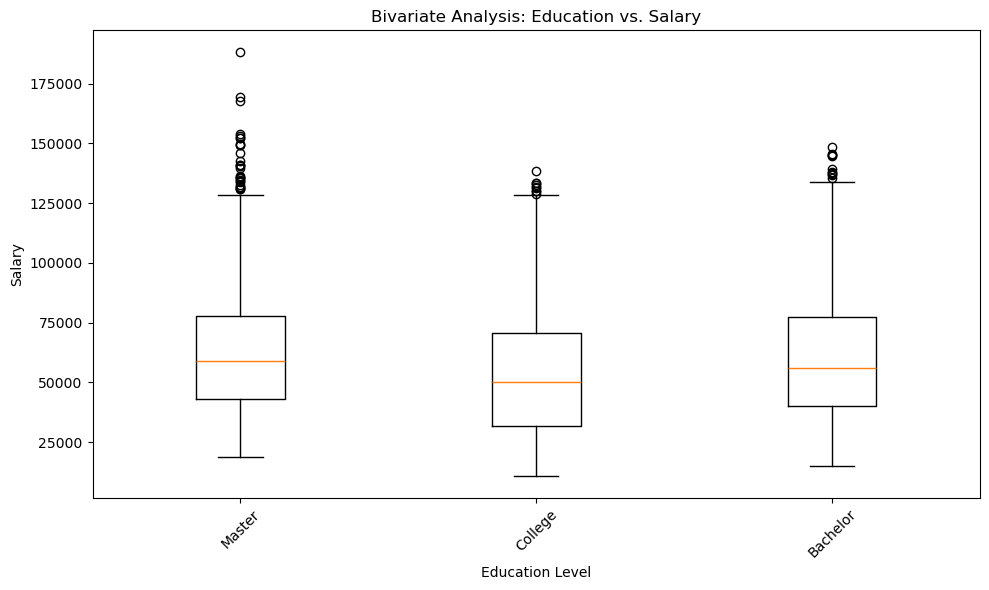

In [ ]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

plt.figure(figsize=(10, 6))

education_levels = df['Education'].unique()

education_groups = [df[df['Education'] == level]['Salary'] for level in education_levels]

plt.boxplot(education_groups, tick_labels=education_levels)

plt.title('Bivariate Analysis: Education vs. Salary')
plt.xlabel('Education Level')
plt.ylabel('Salary')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Boxplot for Salary against Designation
With reference to the boxplot, there is a clear positive relationship between the amount of salary received and their designation as seen by the increasing mean salary of employees at a certain designation. 

However, as seen from the spread of each boxplot, it is interesting to note that having a higher designation level does not necessarily mean that one would have a higher salary

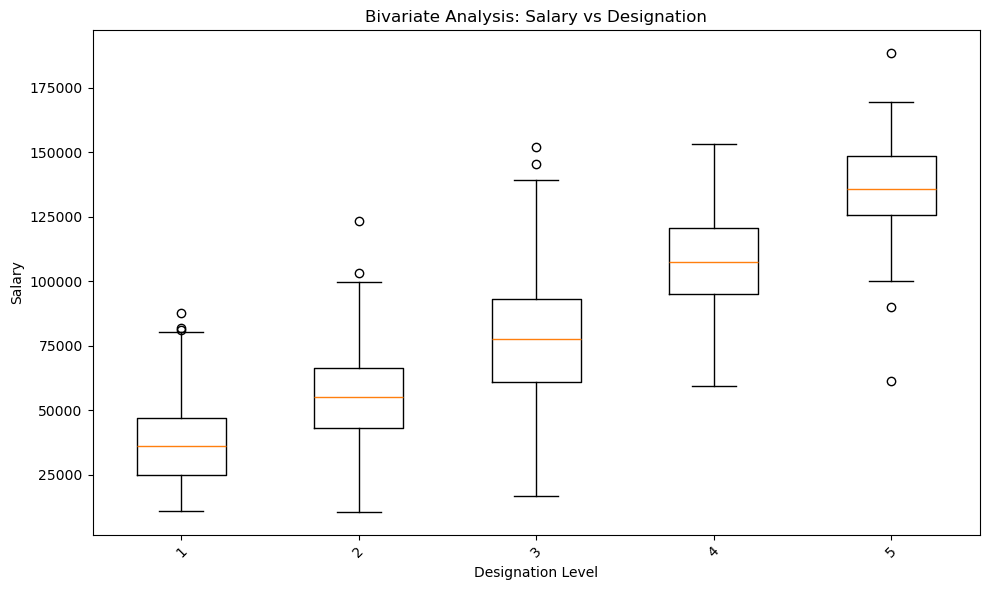

In [123]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

plt.figure(figsize=(10, 6))

designation_levels = df['Designation'].unique()

designation_groups = [df[df['Designation'] == level]['Salary'] for level in designation_levels]

plt.boxplot(designation_groups, tick_labels=designation_levels)

plt.title('Bivariate Analysis: Salary vs Designation')
plt.xlabel('Designation Level')
plt.ylabel('Salary')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Boxplot for Salary against Gender

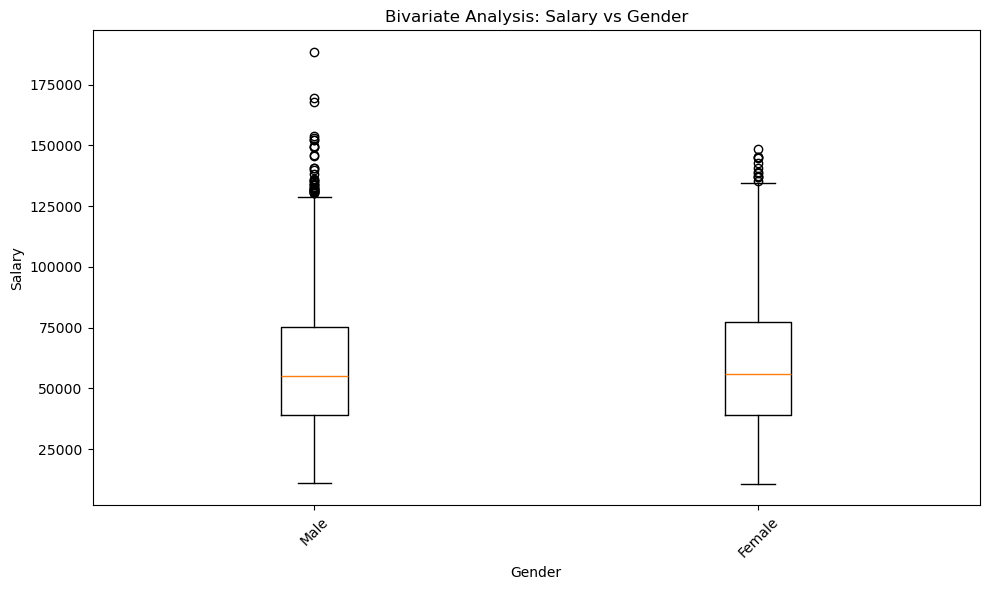

In [99]:
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

plt.figure(figsize=(10, 6))

genders = df['Gender'].unique()

gender_groups = [df[df['Gender'] == gender]['Salary'] for gender in genders]

plt.boxplot(gender_groups, tick_labels=genders)

plt.title('Bivariate Analysis: Salary vs Gender')
plt.xlabel('Gender')
plt.ylabel('Salary')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Boxplot for Total Sales against Gender

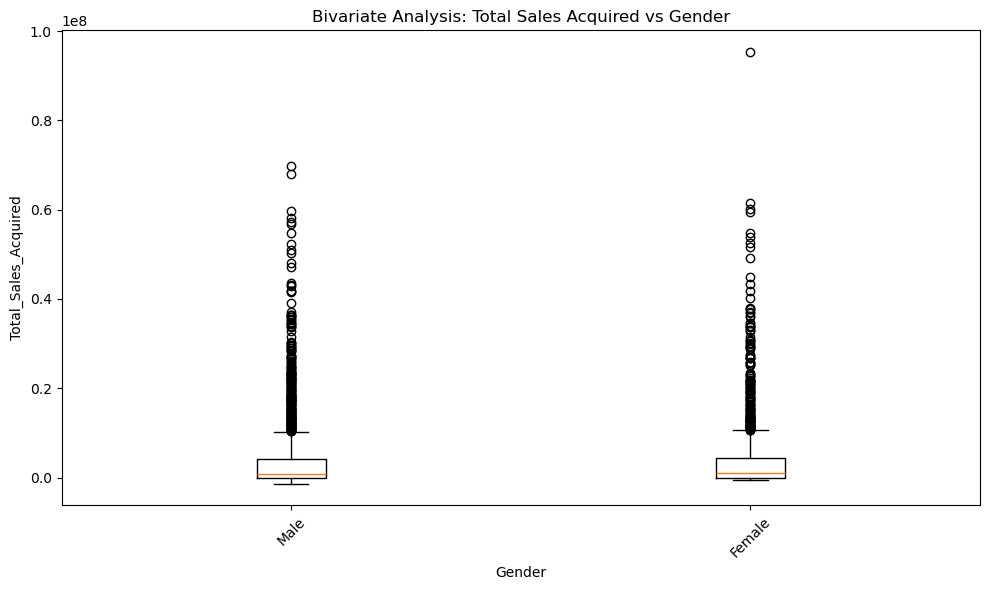

In [106]:
df['Total_Sales_Acquired'] = pd.to_numeric(df['Total_Sales_Acquired'], errors='coerce')

plt.figure(figsize=(10, 6))

genders = df['Gender'].unique()

gender_groups = [df[df['Gender'] == gender]['Total_Sales_Acquired'] for gender in genders]

plt.boxplot(gender_groups, tick_labels=genders)

plt.title('Bivariate Analysis: Total Sales Acquired vs Gender')
plt.xlabel('Gender')
plt.ylabel('Total_Sales_Acquired')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Scatterplot for Salary against Age

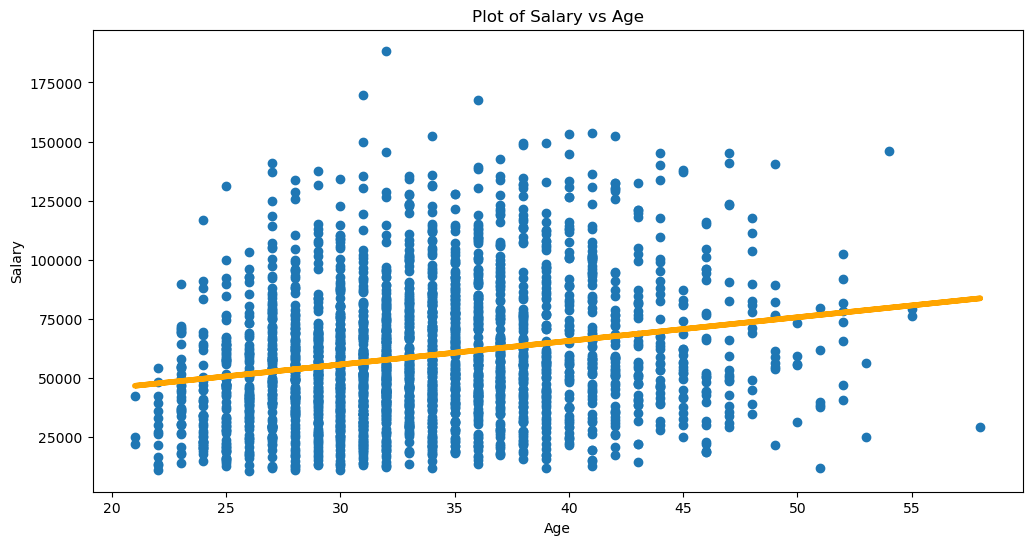

In [89]:
age = df['Age']
salary = df['Salary']
plt.figure(figsize=(12, 6))  
plt.scatter(age,salary)
plt.title("Plot of Salary vs Age")
plt.xlabel("Age")
plt.ylabel("Salary")
# drawing the regression line
line = 1000.01 * age + 25672.63
fig = plt.plot(age,line, lw=4, c='orange', label = 'Regression Line')
plt.show()

### Scatterplot for Total Sales Acquired against Age

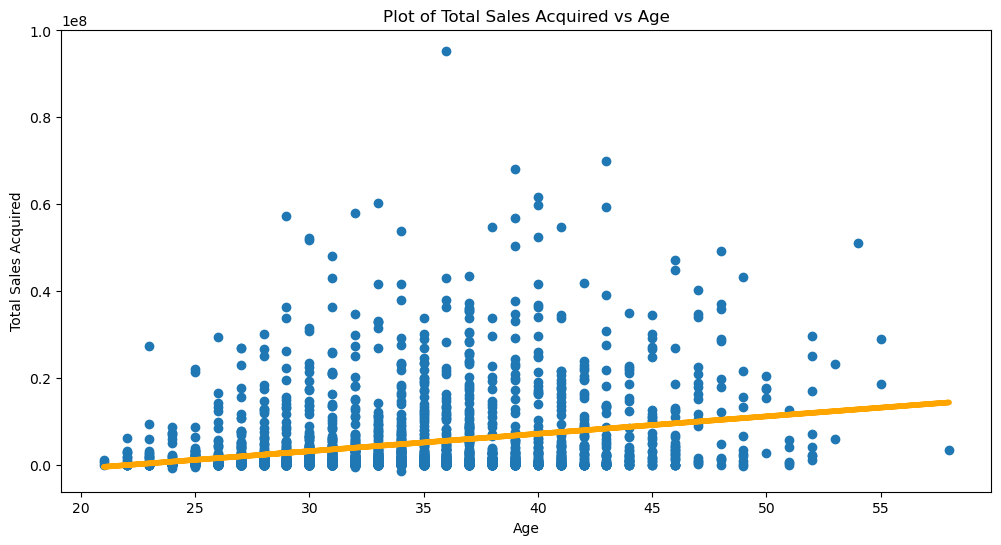

In [94]:
age = df['Age']
sales = df['Total_Sales_Acquired']
plt.figure(figsize=(12, 6))  
plt.scatter(age,sales)
plt.title("Plot of Total Sales Acquired vs Age")
plt.xlabel("Age")
plt.ylabel("Total Sales Acquired")
# drawing the regression line
line2 = 400776.15 * age + -8905221.80
fig = plt.plot(age,line2, lw=4, c='orange', label = 'Regression Line')
plt.show()

### Scatterplot for Total Sales Acquired against Salary

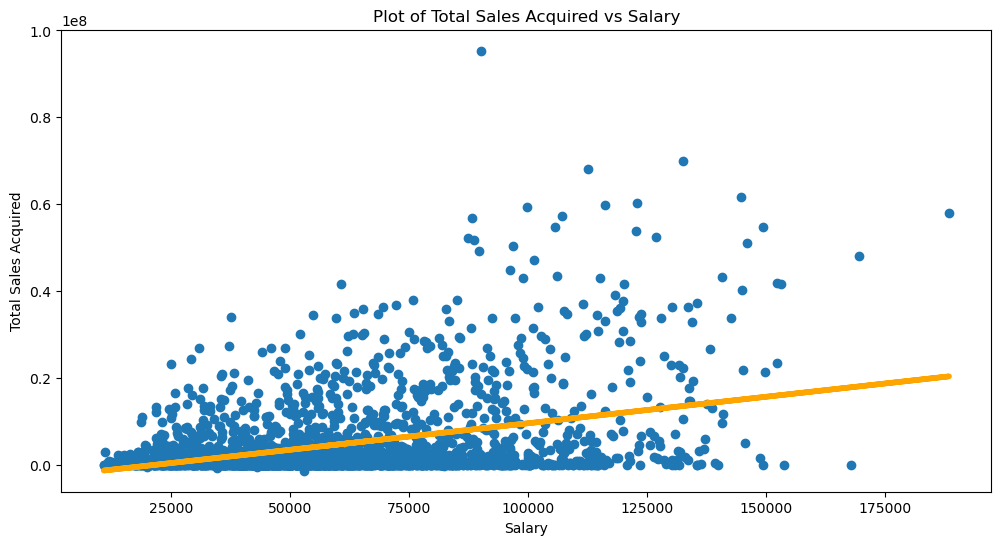

In [104]:
salary = df["Salary"]
sales = df['Total_Sales_Acquired']
plt.figure(figsize=(12, 6))  
plt.scatter(salary,sales)
plt.title("Plot of Total Sales Acquired vs Salary")
plt.xlabel("Salary")
plt.ylabel("Total Sales Acquired")
# drawing the regression line
line3 = 122.09 * salary + -2657931.02
fig = plt.plot(salary,line3, lw=4, c='orange', label = 'Regression Line')
plt.show()

### Histogram for Total Sales against Quarterly Rating